# Castile and Leon: Crops

### Description:
TODO

### Author:
Sergio García Prado ([garciparedes.me](https://garciparedes.me))

## Setting up environment:

#### Cleaning up

In [1]:
rm(list = ls())

#### Library Imports

In [2]:
library(readr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(RSocrata)
library(ca)
library(forcats)
library(reshape2)
library(lubridate)
library(repr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Data Adquisition:

In [3]:
my.read.csv <- function(url, filename) {
    if (!file.exists(filename)) {
        write_csv(read.socrata(url), filename)
    }
    return(read_csv(filename))
}

In [4]:
crops.herbaceous <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/agu2-cspz.csv",
                               "./data/crops-herbaceous.csv")

Parsed with column specification:
cols(
  a_o = col_integer(),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  ocupaci_n_primera_regad_o = col_integer(),
  ocupaci_n_primera_secano = col_integer(),
  ocupaciones_asociadas_regad_o = col_character(),
  ocupaciones_asociadas_secano = col_character(),
  ocupaciones_posteriores_regad_o = col_character(),
  ocupaciones_posteriores_secano = col_character()
)


In [5]:
crops.woody <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/2vwa-si9n.csv",
                           "./data/crops-woody.csv")

Parsed with column specification:
cols(
  a_o = col_datetime(format = ""),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  n_total_arboles_diseminados = col_integer(),
  superficie_regad_o_en_producci_n = col_integer(),
  superficie_regad_o_que_no_pruduce = col_integer(),
  superficie_secano_en_producci_n = col_integer(),
  superficie_secano_que_no_pruduce = col_integer()
)


## Data Cleaning:

#### Remove Unnecesary Columns and Rename Interesting Columns

In [6]:
code.province.to.province <- function(code) {
    recode(code,
           "47" = "Valladolid",
           "24" = "León",
           "34" = "Palencia",
           "37" = "Salamanca",
           "9"  = "Burgos",
           "49" = "Zamora",
           "5"  = "Ávila",
           "42" = "Soria",
           "40" = "Segovia")
}

In [45]:
crops.herbaceous.use <- crops.herbaceous %>%
    select(a_o, codigo_provincia:ocupaci_n_primera_secano) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           crop = cultivo, 
           crop.group = grupo_de_cultivo, 
           region = comarca, 
           town = municipio, 
           irrigation = ocupaci_n_primera_regad_o, 
           dry = ocupaci_n_primera_secano) %>%
    gather(c(dry, irrigation), 
           key = "crop.technique", value = "area") %>%
    filter(!is.na(area) & area > 0 ) %>%
    mutate(crop = factor(crop),
           crop.group = as.factor(crop.group),
           region = as.factor(region),
           town = as.factor(town),
           province = as.factor(code.province.to.province(code.province))) %>%
    select(-code.province)

In [46]:
crops.woody.use <- crops.woody %>%
    select(a_o, codigo_provincia:municipio,
           superficie_regad_o_en_producci_n,
           superficie_secano_en_producci_n) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           crop = cultivo, 
           crop.group = grupo_de_cultivo, 
           region = comarca, 
           town = municipio, 
           irrigation = superficie_regad_o_en_producci_n, 
           dry = superficie_secano_en_producci_n) %>%
    gather(c(dry, irrigation), 
           key = "crop.technique", value = "area") %>%
    filter(!is.na(area) & area > 0 ) %>%
    mutate(crop = as.factor(crop),
           crop.group = as.factor(crop.group),
           region = as.factor(region),
           town = as.factor(town),
           province = as.factor(code.province.to.province(code.province)),
           year = year(round(as.POSIXct(year), "days"))) %>%
    select(-code.province)

In [47]:
crops.use <- rbind(crops.woody.use %>% mutate(crop.type = factor("woody")), 
                   crops.herbaceous.use %>% mutate(crop.type = factor("herbaceous")))

## Data Exploration:

#### View Data Sample

In [48]:
sample_n(crops.use, 10)

year,region,crop,crop.group,town,crop.technique,area,province,crop.type
2011,CIUDAD RODRIGO,AVENA,CEREALES GRANO,SERRADILLA DEL LLANO,irrigation,1,Salamanca,herbaceous
2014,CAMPOS,VIÑEDO DE UVA VINO,VIÑEDO OCUPACIÓN PRINCIPAL,POZO DE URAMA,dry,2,Palencia,woody
2011,CENTRO I,GARBANZO,LEGUMINOSAS GRANO,BERCERO,irrigation,10,Valladolid,herbaceous
2015,EL CERRATO,TRIGO,CEREALES GRANO,REINOSO DE CERRATO,dry,365,Palencia,herbaceous
2014,BIERZO,CASTAÑO FRUTO,FRUTALES,NOCEDA,dry,1,León,woody
2010,BENAVENTE Y LOS VALLES,VEZA,LEGUMINOSAS GRANO,SAN MIGUEL DEL VALLE,dry,3,Zamora,herbaceous
2010,ARLANZON,ALFALFA,CULTIVOS FORRAJEROS,BARRIOS DE COLINA,dry,1,Burgos,herbaceous
2014,SURESTE,GUISANTE SECO,LEGUMINOSAS GRANO,PEÑAFIEL,dry,38,Valladolid,herbaceous
2015,CAMPO DE GOMARA,GIRASOL,CULTIV. INDUSTRIALES,ALMAZUL,dry,709,Soria,herbaceous
2013,AVILA,CENTENO,CEREALES GRANO,SANTA MARIA DEL ARROYO,dry,5,Ávila,herbaceous


In [49]:
summary(crops.use)

      year                         region            crop       
 Min.   :2010   CAMPOS                : 10689   CEBADA : 19305  
 1st Qu.:2011   CUELLAR               :  9783   TRIGO  : 17031  
 Median :2013   DUERO BAJO            :  8400   GIRASOL: 14123  
 Mean   :2013   CAMPOS-PAN            :  8350   AVENA  : 12975  
 3rd Qu.:2015   AREVALO-MADRIGAL      :  8343   CENTENO: 11301  
 Max.   :2016   BENAVENTE Y LOS VALLES:  8063   ALFALFA: 10584  
                (Other)               :150839   (Other):119148  
                crop.group             town        crop.technique    
 CEREALES GRANO      :73516   TORO       :   499   Length:204467     
 CULTIVOS FORRAJEROS :41015   CUELLAR    :   387   Class :character  
 LEGUMINOSAS GRANO   :29436   VALLADOLID :   366   Mode  :character  
 CULTIV. INDUSTRIALES:25781   TORDESILLAS:   343                     
 HORTALIZAS          :12645   FUENTESAUCO:   328                     
 TUBERCULOS          : 6903   ZAMORA     :   322            

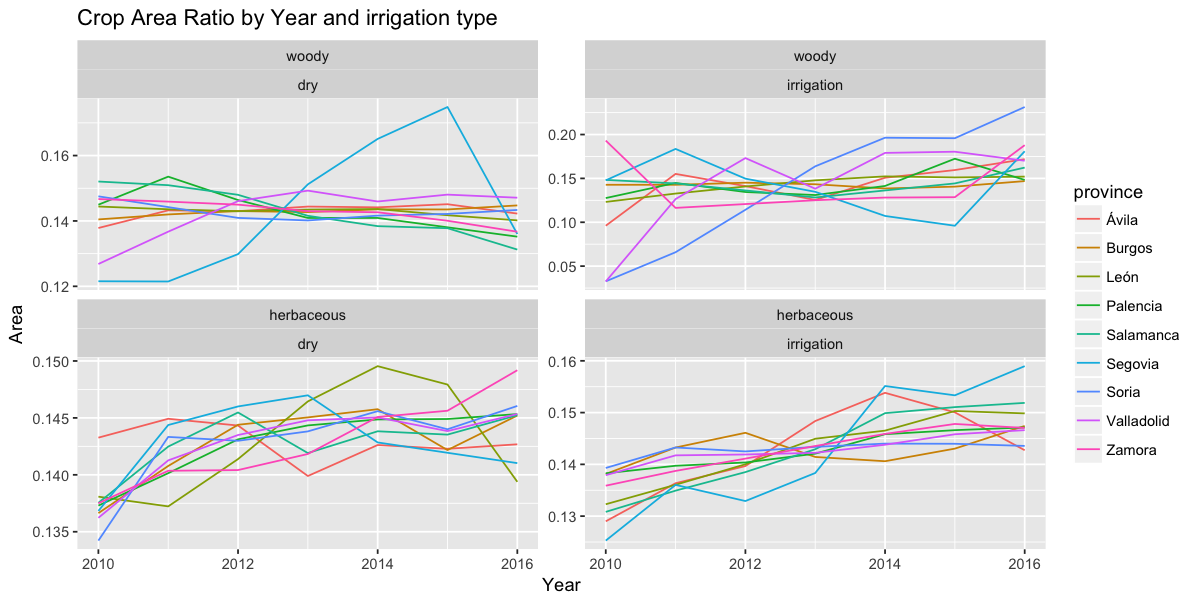

In [52]:
options(repr.plot.width = 10, repr.plot.height = 5)
crops.use %>%
    select(year, area, crop.type, crop.technique, province) %>%
    group_by(year, crop.type, crop.technique, province) %>%
    summarise(area = sum(area)) %>%
    group_by(crop.type, crop.technique, province) %>%
    mutate(area = area / sum(area)) %>%
    ggplot(aes(x=year, y = area, 
               group = province,
               col = province)) +
        labs(title = "Crop Area Ratio by Year and irrigation type", 
             x = "Year", y = "Area") + 
        facet_wrap( ~ crop.type + crop.technique, scales = "free_y") +
        geom_line()

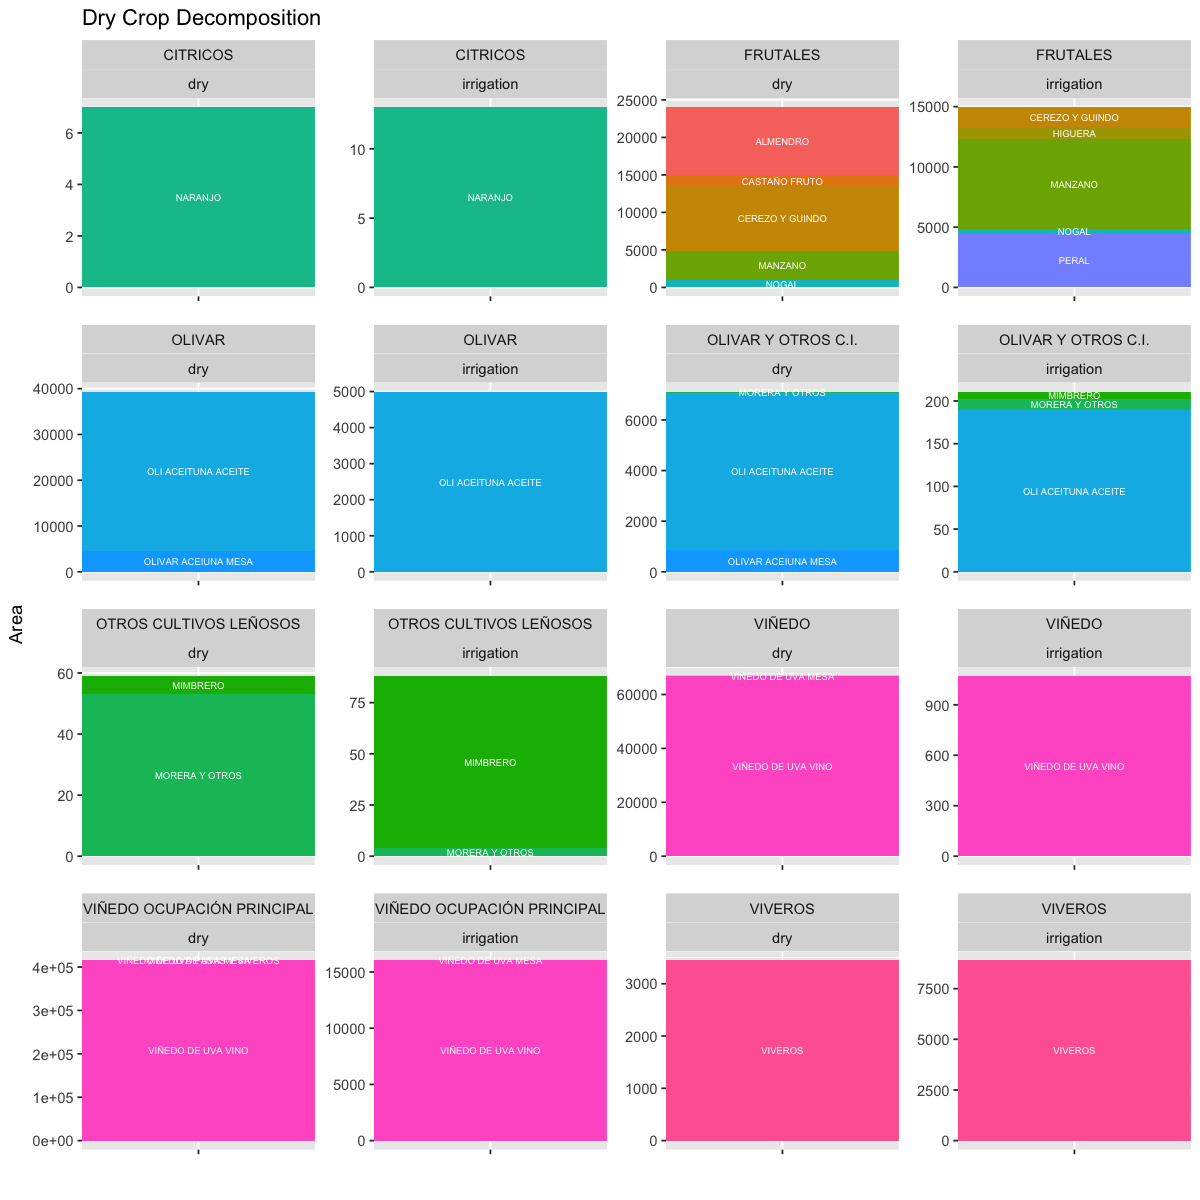

In [54]:
options(repr.plot.width = 10, 
        repr.plot.height = 10)
crops.use %>%
    select(crop, crop.type, crop.group, crop.technique, area) %>%
    filter(crop.type == "woody") %>%
    group_by(crop.group, crop.type, crop.technique, crop) %>%
    summarise(area = sum(area)) %>%
    top_n(5, area) %>%
    ggplot(aes(x = "", y = area, fill = crop, label = crop)) + 
        geom_bar(width = 1, stat = "identity") +
        theme(legend.position='none') + 
        labs(title = "Dry Crop Decomposition", 
             x = "", y = "Area") + 
        facet_wrap( ~ crop.group + crop.technique, scales = "free", shrink = FALSE)+ 
        geom_text(size = 2, position = position_stack(vjust = 0.5), 
                  colour = "white") 

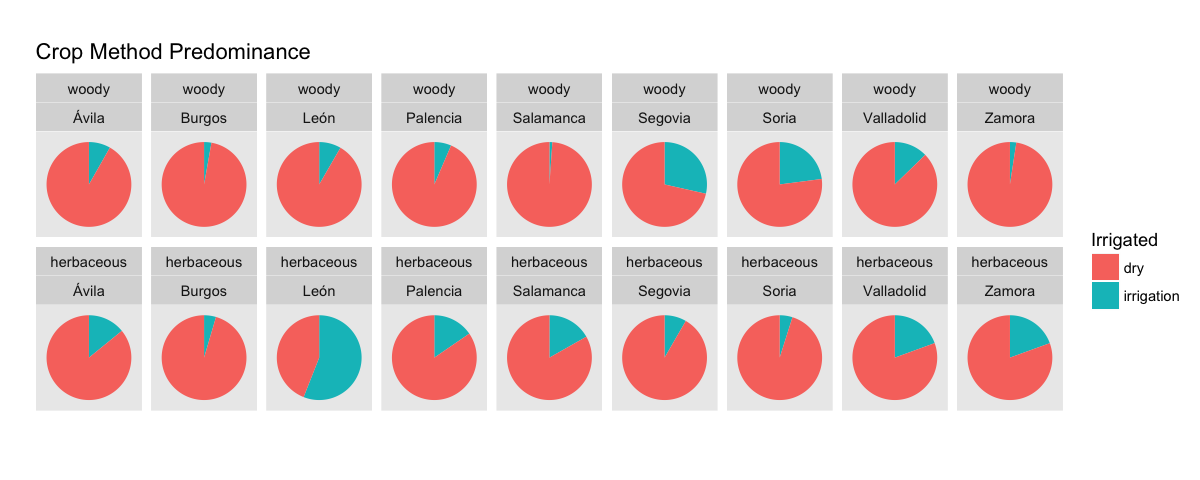

In [63]:
options(repr.plot.width = 10, 
        repr.plot.height = 4)
crops.use %>%
    select(area, crop.type, crop.technique, province) %>%
    group_by(province, crop.type, crop.technique) %>%
    summarise(area = sum(area)) %>%
    group_by(province, crop.type) %>%
    mutate(area = area / sum(area)) %>%
    ggplot(aes(x = "", y = area, fill = crop.technique)) +
        geom_bar(stat = "identity", width = 1) +
        labs(title = "Crop Method Predominance", 
             x = "", y = "", fill = "Irrigated") +
        coord_polar(theta = "y") + 
        facet_wrap(crop.type ~ province, ncol= 9) +
        theme(axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid  = element_blank())
        

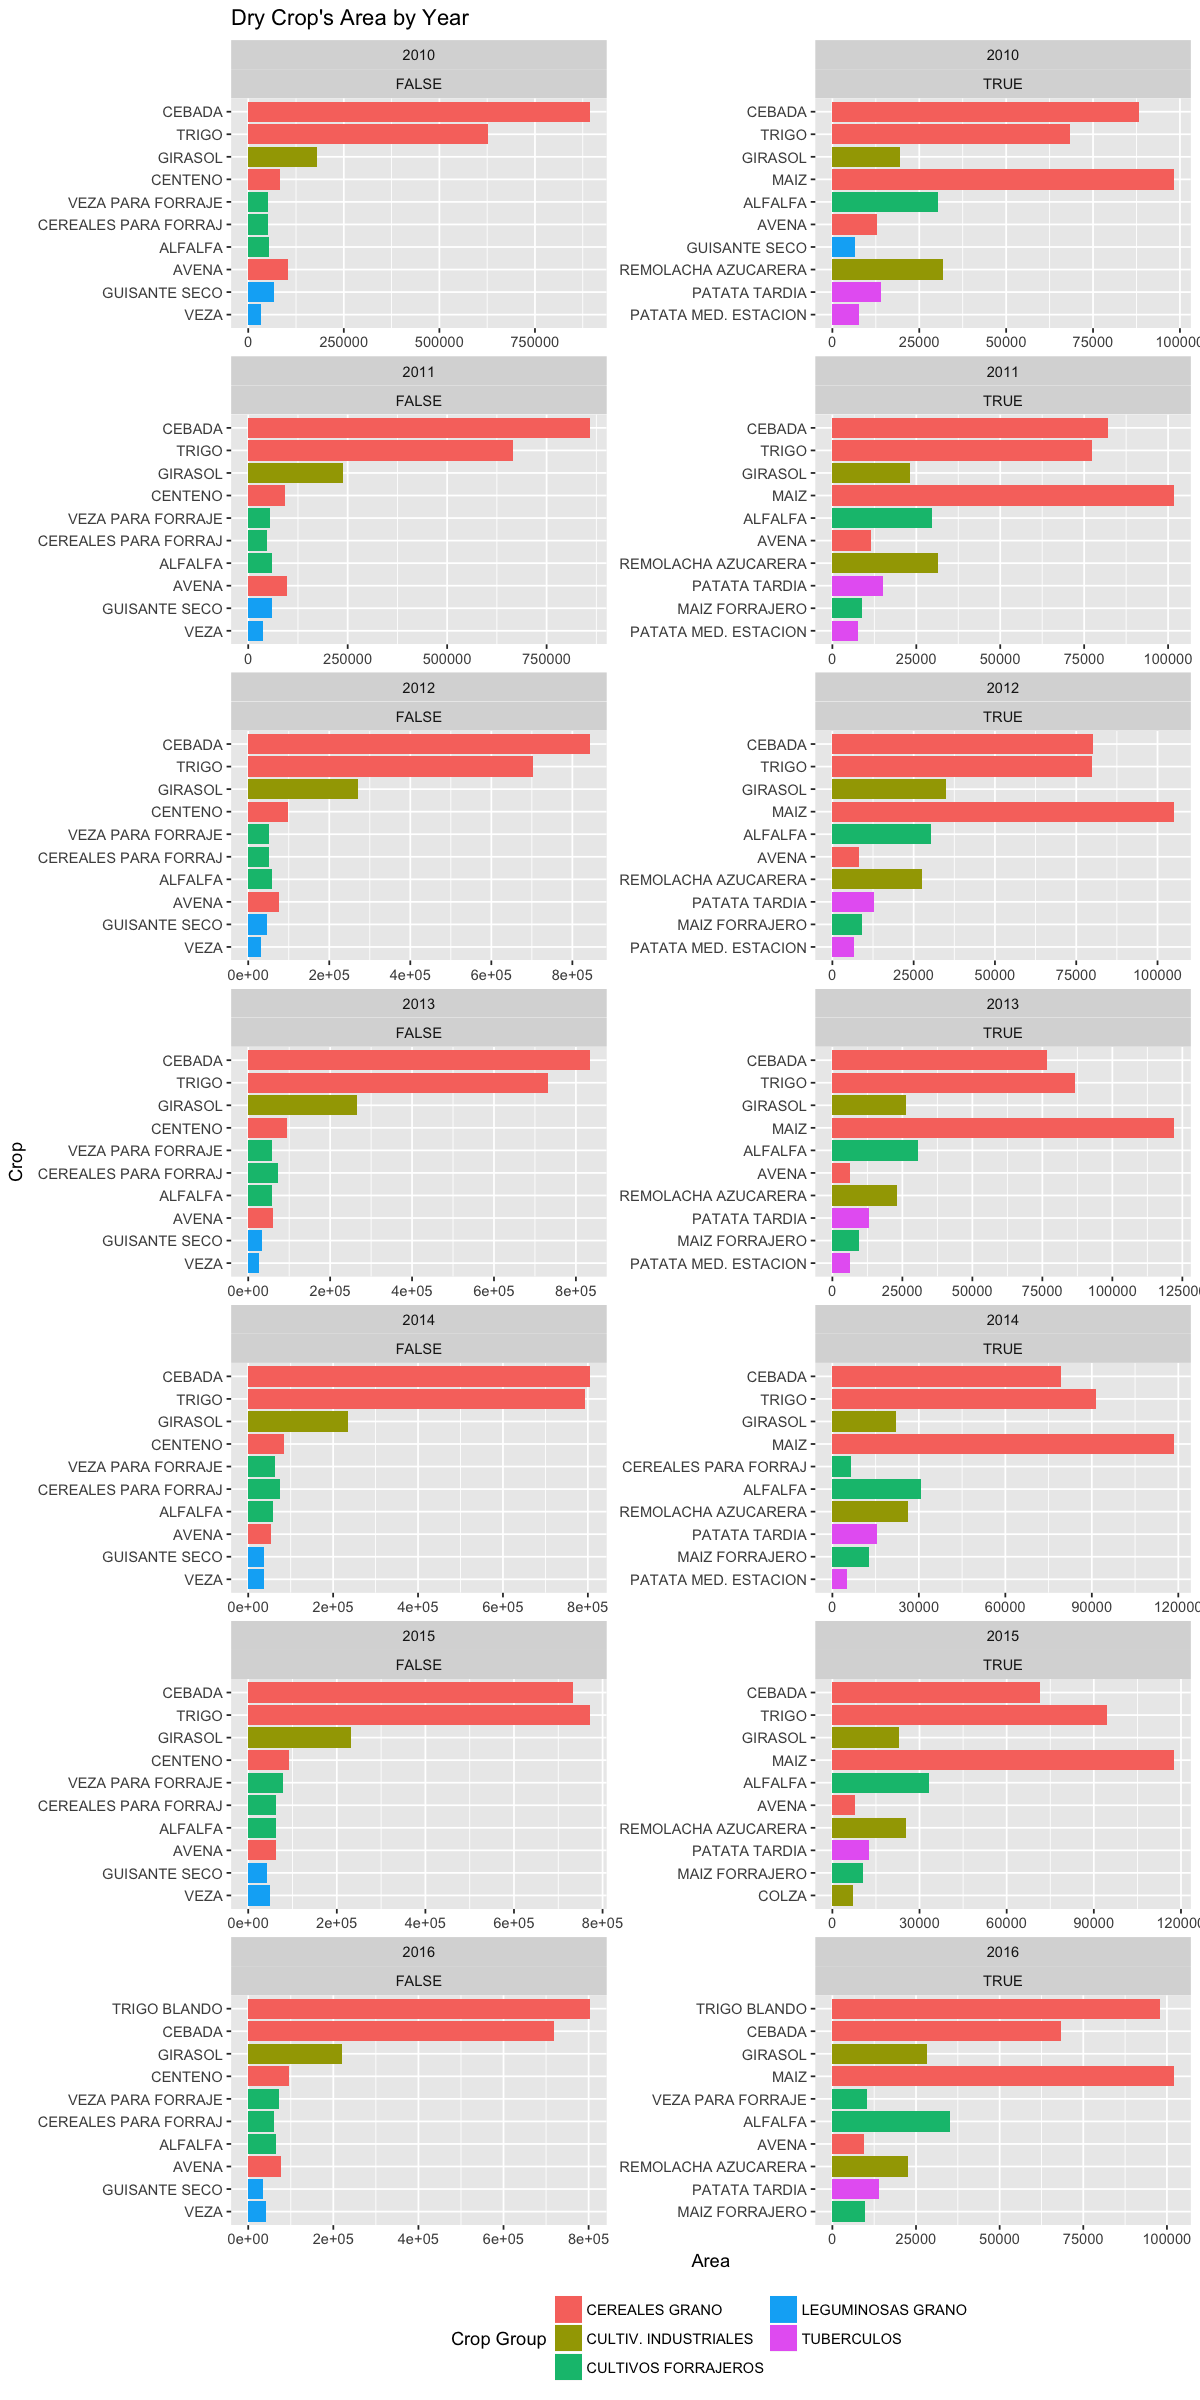

In [15]:
options(repr.plot.width = 10, 
        repr.plot.height = 20)
crops.herbaceous.use %>%
  select(crop, year,irrigated, crop.group, area) %>%
  filter(area > 0) %>%
  group_by(crop.group,irrigated, year, crop) %>%
  summarise(area = sum(area, na.rm = TRUE)) %>%
  ungroup() %>%
  group_by(year, irrigated) %>%
  top_n(10, area) %>%
  ggplot(aes(x = reorder(crop, area), y = area)) + 
    geom_bar(aes(fill = crop.group), stat = "identity") + 
    theme(legend.position='bottom') +  
    guides(fill = guide_legend(ncol = 2)) +
    labs(title = "Dry Crop's Area by Year", 
         x = "Crop", y = "Area", fill = "Crop Group") +
    coord_flip() + 
    facet_wrap(~year + irrigated, scales = "free", ncol = 2)

### Correspondence Analysis

In [16]:
crops.woody.use.ca <- crops.woody.use %>%
    select(crop.group, province, area) %>%
    filter(area > 0) %>%
    xtabs(formula = area ~ .,
          drop.unused.levels = TRUE) %>%
    ca()
summary(crops.woody.use.ca)

Warning message in abbreviate(rnames.temp, 4):
“abbreviate used with non-ASCII chars”Warning message in abbreviate(rnames.temp, 4):
“abbreviate used with non-ASCII chars”Warning message in abbreviate(rnames.temp, 4):
“abbreviate used with non-ASCII chars”Warning message in abbreviate(rnames.temp, 4):
“abbreviate used with non-ASCII chars”Warning message in abbreviate(cnames.temp, 4):
“abbreviate used with non-ASCII chars”


Principal inertias (eigenvalues):

 dim    value      %   cum%   scree plot               
 1      0.347809  59.3  59.3  ***************          
 2      0.185978  31.7  91.0  ********                 
 3      0.048196   8.2  99.2  **                       
 4      0.003476   0.6  99.8                           
 5      0.000944   0.2 100.0                           
 6      0.000194   0.0 100.0                           
 7      00000000   0.0 100.0                           
        -------- -----                                 
 Total: 0.586597 100.0                                 


Rows:
       name   mass  qlt  inr    k=1 cor ctr    k=2 cor ctr  
1 |    CITR |    0  512    1 | 2468 488   1 | -546  24   0 |
2 |    FRUT |   71  479  127 |  686 450  97 | -174  29  12 |
3 |  OLIVAR |   73  969  389 | 1734 964 632 | -127   5   6 |
4 | OLIVARY |   12  981   71 | 1831 975 116 | -145   6   1 |
5 |    OTRO |    0  148    7 | 1547 138   2 | -423  10   0 |
6 |  VIÑEDO |  112  882   12 |

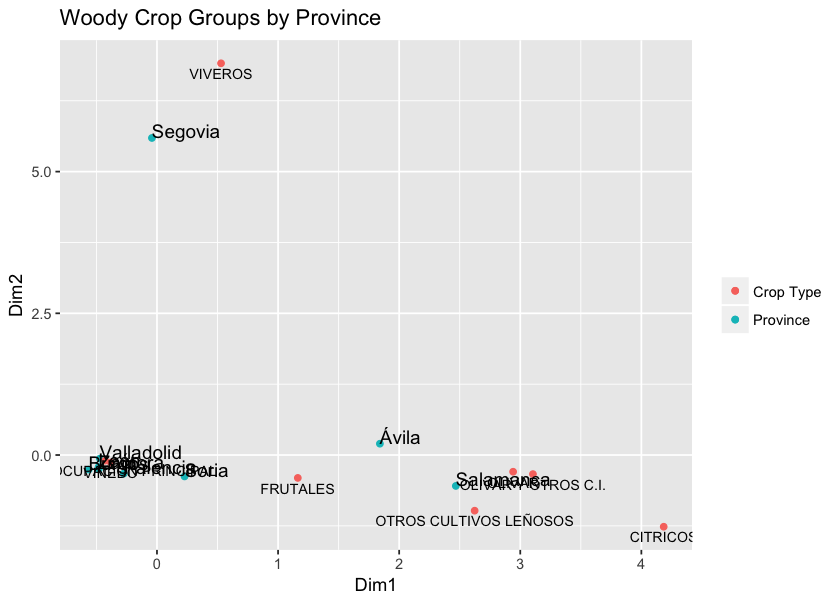

In [17]:
options(repr.plot.width = 7, 
        repr.plot.height = 5)
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    labs(title = "Woody Crop Groups by Province", 
         colour = "") +
    geom_point(data = as.data.frame(crops.woody.use.ca$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.woody.use.ca$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.woody.use.ca$rowcoord),
              label=rownames(crops.woody.use.ca$rowcoord), 
              hjust=0.5, vjust=1.5, size = 3) +
    geom_text(data = as.data.frame(crops.woody.use.ca$colcoord),
              label=rownames(crops.woody.use.ca$colcoord), 
              hjust=0, vjust=0, size = 4)


In [18]:
crops.herbaceous.use.ca <- crops.herbaceous.use %>%
    select(crop.group, province, area) %>%
    filter(area > 0) %>%
    xtabs(formula = area ~ .,
          drop.unused.levels = TRUE) %>%
    ca()
summary(crops.herbaceous.use.ca.irrigation)

ERROR: Error in summary(crops.herbaceous.use.ca.irrigation): object 'crops.herbaceous.use.ca.irrigation' not found


In [ ]:
options(repr.plot.width = 7, 
        repr.plot.height = 5)
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    labs(title = "Herbaceous Crop Groups by Province", 
         colour = "") +
    geom_point(data = as.data.frame(crops.herbaceous.use.ca$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.herbaceous.use.ca$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.herbaceous.use.ca$rowcoord),
              label=rownames(crops.herbaceous.use.ca$rowcoord), 
              hjust=0.5, vjust=1.5, size = 3) +
    geom_text(data = as.data.frame(crops.herbaceous.use.ca$colcoord),
              label=rownames(crops.herbaceous.use.ca$colcoord), 
              hjust=0, vjust=0, size = 4)